In [1]:
import os
import numpy as np
import mne
import imageio
import h5py
from datetime import datetime
from datetime import timedelta
# import scipy.fftpack
import matplotlib
import pywt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
# from scipy import signal
from matplotlib.colors import ListedColormap
import time
import seaborn as sns
# import scipy.io as sio
# from scipy.integrate import simps
import pandas as pd
# from scipy import fft
import matplotlib.mlab as mlab
import sys

sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis\py_functions')
import NMF_funcs as NMFf

from scipy.stats import norm
import LL_funcs
from scipy.stats import norm
from tkinter import filedialog
from tkinter import *
import ntpath

root = Tk()
root.withdraw()
import math
import scipy
from scipy import signal
import pylab
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import platform
from glob import glob
from scipy.io import savemat
import scipy.cluster.hierarchy as spc
from scipy.spatial import distance
from sklearn.cluster import KMeans
import h5py
import basic_func as bf
from scipy.integrate import simps
from numpy import trapz
#import IO_func as IOF
#import BM_func as BMf
import tqdm
from matplotlib.patches import Rectangle
from pathlib import Path
sub_path  ='X:\\4 e-Lab\\' # y:\\eLab

import freq_funcs as ff

regions = pd.read_excel("T:\EL_experiment\Patients\\" + 'all' + "\elab_labels.xlsx", sheet_name='regions', header=0)
color_regions = regions.color.values
regions = regions.label.values

CR_color = pd.read_excel("T:\EL_experiment\Patients\\" + 'all' + "\Analysis\BrainMapping\CR_color.xlsx", header=0)
CR_color_a = CR_color.a.values
CR_color = CR_color.c.values
CR_color = np.zeros((24, 3))
CR_color[6:18, :] = np.array([253, 184, 19]) / 255

dist_groups = np.array([[0, 30], [30, 60], [60, 120]])
dist_labels = ['local (<30 mm)', 'short (<60mm)', 'long']
Fs = 500
dur = np.zeros((1, 2), dtype=np.int32)
t0 = 1
dur[0, 0] = -t0
dur[0, 1] = 3

folder = 'BrainMapping'
# dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax = np.arange(dur[0, 0], dur[0, 1], (1 / Fs))
color_elab = np.zeros((3, 3))
color_elab[0, :] = np.array([31, 78, 121]) / 255
color_elab[1, :] = np.array([189, 215, 238]) / 255
color_elab[2, :] = np.array([0.256, 0.574, 0.431])
cwd = os.getcwd()

In [2]:
color_sleep = ['#808080', '#145da0', '#ff1919']
label_sleep = ['Wake', 'NREM', 'REM']
color_dist = ['0000FF','#0076C4','#00DD91']

In [3]:
cond_folder = 'CR'  # Condition = 'Hour', 'Condition', 'Ph'
if cond_folder == 'Ph':
    cond_vals = np.arange(4)
    cond_labels = ['BM', 'BL', 'Fuma', 'BZD']
    cond_colors = ['#494159', '#594157', "#F1BF98", "#8FB996"]
    cond1 = 'Condition'  # 'condition', 'h'
    cond_folder = 'Ph'  # 'Ph', 'Sleep', 'CR'
    Condition = 'Condition'
if cond_folder == 'CR':
    Condition = 'Hour'  # Condition = 'Hour'
    cond1 = 'h'  # h (as stored in stimlist)

In [716]:
start = 1
for subj in ['EL012', 'EL024', 'EL015', 'EL019', 'EL013','EL027', 'EL014']:
    path_patient_analysis = sub_path+'\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj

    file_con = os.path.join(path_patient_analysis, 'preIctal', 'table_preIctal.csv')
    table = pd.read_csv(file_con)
    if start:
        table_sz = table
        start = 0
    else:
        table_sz = pd.concat([table_sz, table]).reset_index(drop=True)
table_sz = table_sz[table_sz.SOZ != 'non-sig'].reset_index(drop=True)
table_sz.loc[table_sz.SOZ == 'Propagation', 'SOZ'] ='SOZ'
table_sz['Con_ID'] = table_sz.groupby(['Subj', 'Con_ID']).ngroup()
table_sz['SZ_ID'] = table_sz.groupby(['Subj', 'SZ']).ngroup()

In [575]:
# normalize by time (channel specific)
table_sz['LL_norm'] = table_sz.groupby(['SZ_ID', 'SOZ'], group_keys=False)['LL_z'].apply(
        lambda x: (x - x.mean()) / x.std())


In [724]:
table_sz_ID = table_sz.groupby(['SZ_ID','SOZ', 'TtSZ'], as_index=False)['LL_z','LL_norm'].mean()

C:\Users\i0328442\AppData\Local\Temp\ipykernel_9308\2907465863.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  table_sz_ID = table_sz.groupby(['SZ_ID','SOZ', 'TtSZ'], as_index=False)['LL_z','LL_norm'].mean()


Text(0.5, 1.0, 'Mean response across non-ictogenic tissue for each seizure')

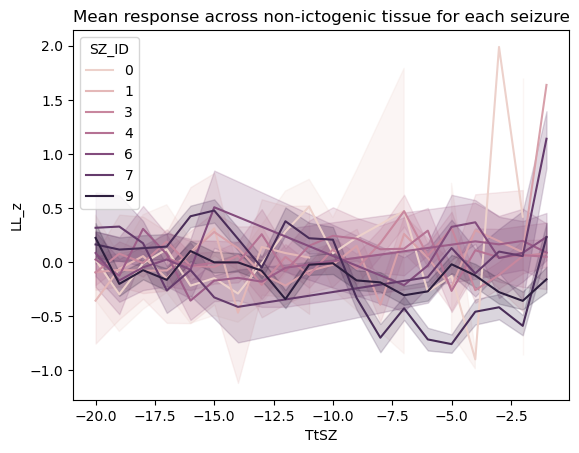

In [726]:
sns.lineplot(x='TtSZ', y='LL_z', hue='SZ_ID', data=table_sz[(table_sz.IPI==0)&(table_sz.SOZ=='non-ictogenic tissue')])
plt.title('Mean response across non-ictogenic tissue for each seizure')

Text(0.5, 1.0, 'Mean response across ictogenic tissue for each seizure')

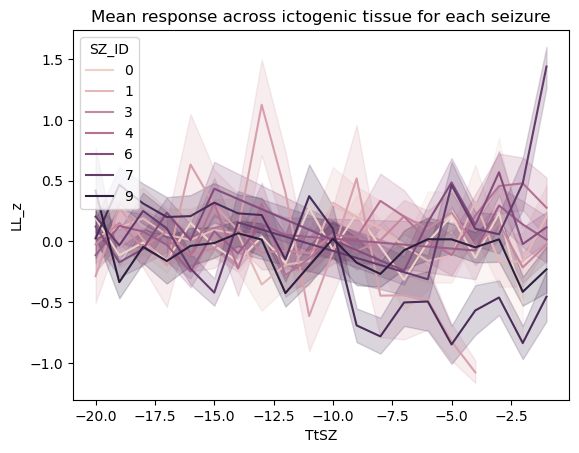

In [727]:
sns.lineplot(x='TtSZ', y='LL_z', hue='SZ_ID', data=table_sz[(table_sz.IPI==0)&(table_sz.SOZ=='ictogenic tissue')])
plt.title('Mean response across ictogenic tissue for each seizure')

Text(0.5, 0, 'Time to SZ [min]')

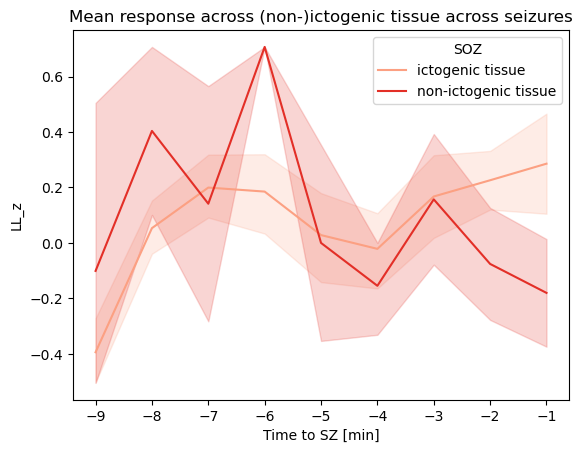

In [731]:
sns.lineplot(x='TtSZ', y='LL_z', hue='SOZ', data=table_sz[(table_sz.IPI==0)], palette='Reds')
plt.title('Mean response across (non-)ictogenic tissue across seizures')
plt.xlabel('Time to SZ [min]')

In [729]:
sns.lineplot(x='TtSZ', y='LL_z', hue='SOZ', data=table_sz_ID[(table_sz_ID.IPI==0)], palette='Reds')
plt.title('Mean response across (non-)ictogenic tissue across seizures')
plt.xlabel('Time to SZ [min]')

AttributeError: 'DataFrame' object has no attribute 'IPI'

<Axes: xlabel='TtSZ', ylabel='LL_norm'>

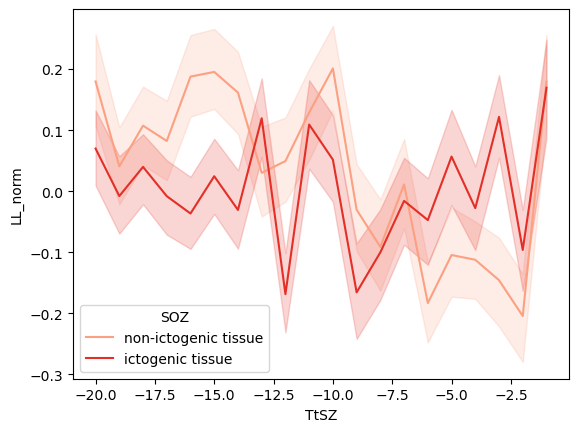

In [723]:
sns.lineplot(x='TtSZ', y='LL_norm', hue='SOZ', data=table_sz, palette='Reds')

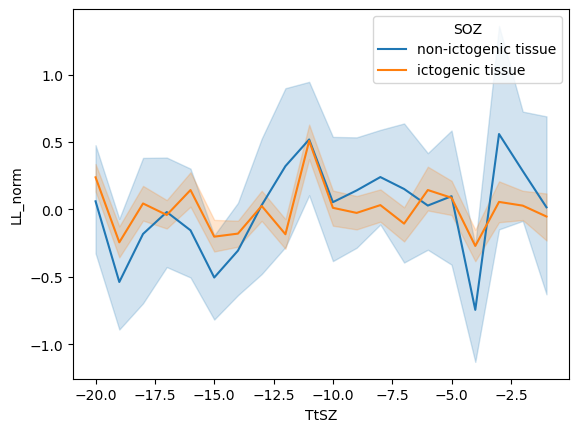

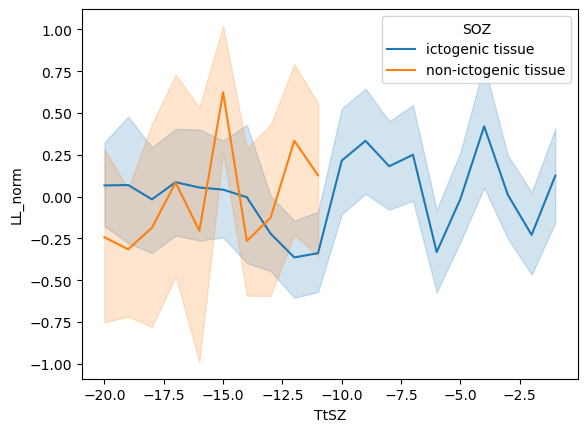

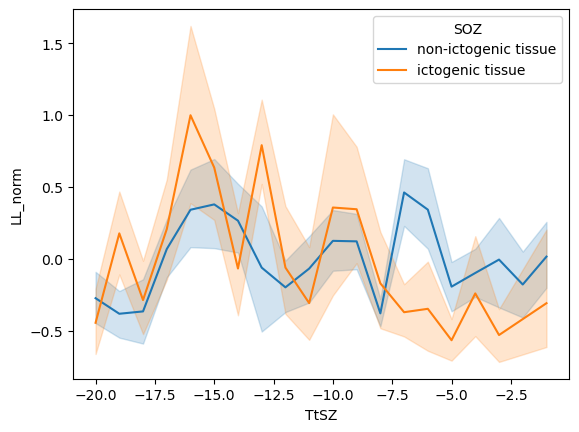

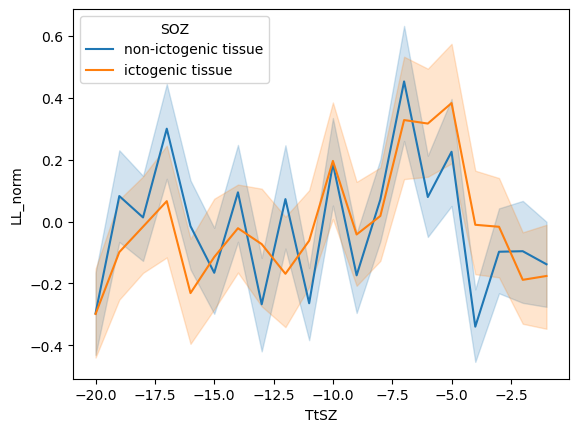

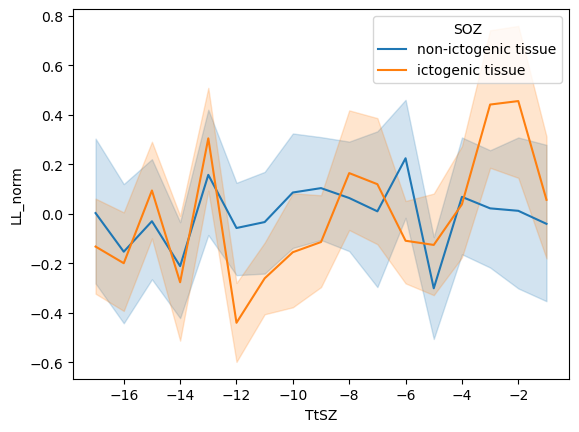

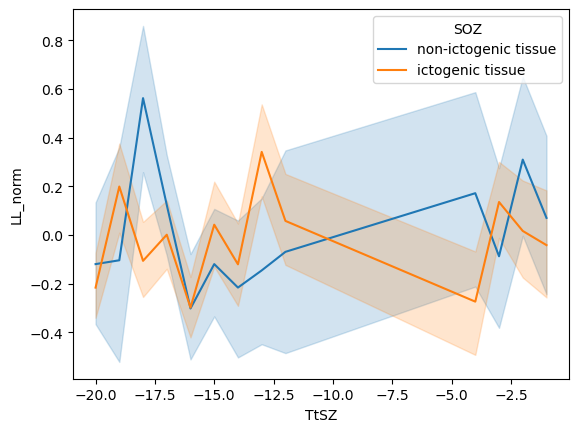

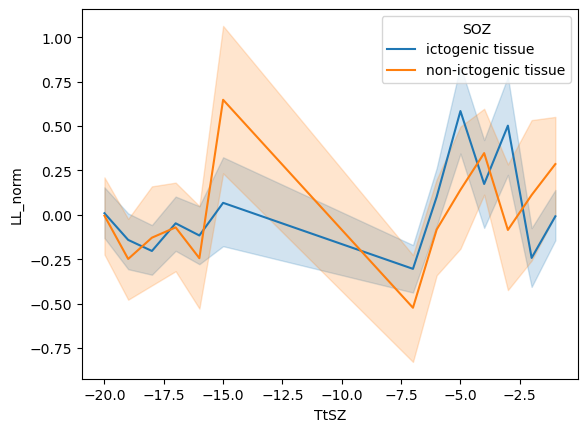

In [551]:
for sz_id in np.unique(table_sz.SZ_ID):
    sns.lineplot(x='TtSZ', y='LL_norm', hue='SOZ', data=table_sz[table_sz.SZ_ID==sz_id])
    plt.show()

In [13]:
table_sz

,Subj,Con_ID,Stim,Chan,Int,TtSZ,TtSZ_s,LL_norm,SOZ,PreIctal,SZ
0,EL012,223,8,0,3.0,-30.0,-1796.0,-0.100950,uninvolved,>7min,1
1,EL012,224,8,1,3.0,-30.0,-1796.0,0.281877,uninvolved,>7min,1
2,EL012,225,8,2,3.0,-30.0,-1796.0,1.363508,uninvolved,>7min,1
3,EL012,226,8,3,3.0,-30.0,-1796.0,2.111477,uninvolved,>7min,1
4,EL012,227,8,4,3.0,-30.0,-1796.0,0.683794,uninvolved,>7min,1
...,...,...,...,...,...,...,...,...,...,...,...
97027,EL014,2986,53,7,2.0,-1.0,-3.0,-0.183079,SOZ,>0min,1
97028,EL014,2987,53,14,2.0,-1.0,-3.0,-0.214244,SOZ,>0min,1
97029,EL014,2988,53,22,2.0,-1.0,-3.0,-0.174774,SOZ,>0min,1
97030,EL014,2989,53,47,2.0,-1.0,-3.0,-0.137714,SOZ,>0min,1


In [ ]:
stop

### Plotting

In [606]:
subj = "EL024"
path_patient_analysis = os.path.join(sub_path, 'EvM', 'Projects', 'EL_experiment', 'Analysis', 'Patients', subj)
chan_labels = ['SOZ', 'Propagation', 'uninvolved']
path_gen = os.path.join(sub_path+'\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
path_infos = os.path.join(path_gen, 'Electrodes')
# labels
files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*')
i = 0
stimlist_file = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\stimlist_' + cond_folder + '.csv'
stimlist = pd.read_csv(stimlist_file)
lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
if "type" in lbls.columns:
    lbls = lbls[lbls.type=='SEEG']
    lbls = lbls.reset_index(drop=True)
labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM, StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(
    stimlist,
    lbls)
stimlist_sleep = pd.read_csv(os.path.join(path_patient_analysis, 'stimlist_hypnogram.csv'))
file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
con_trial = pd.read_csv(file_con)
badchans = pd.read_csv(path_patient_analysis + '/BrainMapping/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:, 1:] == 1))[0, :])

In [638]:
bad_chans

array([ 61,  62, 109], dtype=int64)

In [607]:
h5_file = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_' + cond_folder + '.h5'
if os.path.isfile(h5_file):
    print('loading h5')
    EEG_resp = h5py.File(h5_file)
    EEG_resp = EEG_resp['EEG_resp']
print(EEG_resp.shape)
print(len(stimlist))

loading h5
(110, 17204, 2000)
17027


In [608]:
sz_log = pd.read_excel(os.path.join(sub_path, 'Patients', subj, 'Data', 'EL_experiment', 'SZ_log.xlsx'))
sz_log = sz_log[~np.isnan(sz_log.SZ)].reset_index(drop=True)
if "sel" in sz_log:
    sz_log = sz_log[sz_log.sel==1].reset_index(drop=True)

ix_sz = 1
time_sz = datetime.combine(sz_log.Date[ix_sz].to_pydatetime().date(), sz_log.Time[ix_sz])
SOZ_label = sz_log.SOZ_label[ix_sz]

In [642]:
con_trial['Con_ID'] = con_trial.groupby(['Stim', 'Chan']).ngroup()
# find significant connections
con_summary = con_trial.groupby(['Con_ID', 'Stim', 'Chan'], as_index=False)['Sig'].mean()
con_summary = con_summary[con_summary.Sig > 0.8].reset_index(drop=True)
con_sig = con_summary.Con_ID.values

In [643]:
trials_preictal = con_trial[
        ((pd.to_datetime(con_trial['Time']) - time_sz) > timedelta(seconds=-1 * 3600)) & (
                (pd.to_datetime(con_trial['Time']) - time_sz) < timedelta(
            seconds=0.05 * 3600))].reset_index(drop=True)
# Create a new column 'TimeDiffSeconds' in the DataFrame
trials_preictal['TtSZ_s'] = np.round(
    ((pd.to_datetime(trials_preictal['Time']) - time_sz).dt.total_seconds()))

In [644]:
# connections
trials_preictal.insert(0, 'SOZ', 'non-sig')
for chan_label_ix in range(len(chan_labels)):
    chan_sel = np.where(lbls[SOZ_label] == chan_label_ix)[0]
    trials_preictal.loc[np.isin(trials_preictal.Con_ID, con_sig) & np.isin(trials_preictal.Chan, chan_sel), 'SOZ'] = \
    chan_labels[chan_label_ix]
trials_preictal= trials_preictal[trials_preictal.SOZ!='non-sig'].reset_index(drop=True)
trials_preictal= trials_preictal[~np.isin(trials_preictal.Chan, bad_chans)].reset_index(drop=True)

In [645]:
np.unique(trials_preictal.loc[(trials_preictal.TtSZ_s>-60)&(trials_preictal.TtSZ_s<0)&(trials_preictal.SOZ=='SOZ'),'Stim'])

array([ 1,  3,  9, 28, 31, 33, 37, 40, 41, 60, 76, 81, 84], dtype=int64)

In [646]:
data_show = trials_preictal.loc[(trials_preictal.TtSZ_s>-60)&(trials_preictal.TtSZ_s<0)&(trials_preictal.SOZ=='SOZ')].reset_index(drop=True)
k = -1

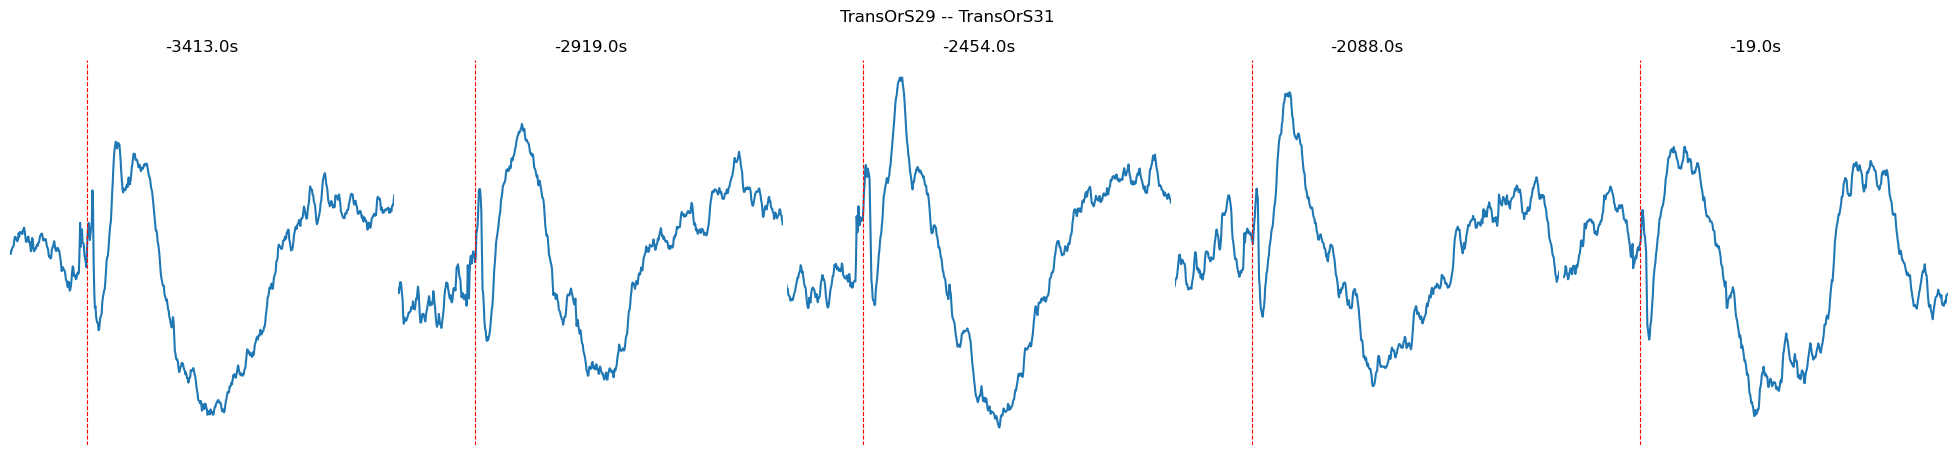

In [679]:
k = k+1
rc = data_show.Chan.values[k]
sc = data_show.Stim.values[k]
num = trials_preictal.loc[(trials_preictal.Chan == rc)&(trials_preictal.Stim == sc), 'Num'].values
channel_data = EEG_resp[rc, num, :]  # Shape: (num, 2000)
fig, axes = plt.subplots(1, len(num), figsize=(25, 5), sharey=True, sharex = True, gridspec_kw={'wspace': 0.01})
plt.suptitle(labels_all[sc]+ ' -- '+labels_all[rc])
# Plot each trial one after the other
ictal = 0
for i in range(len(num)):
    trial_data = channel_data[i, :]
    d_sec = trials_preictal.loc[(trials_preictal.Chan == rc)&(trials_preictal.Stim == sc), 'TtSZ_s'].values[i]
    
    if (ictal ==0)& ( d_sec >0):
        axes[i].axvline(x=-0.25, color='g', linestyle='--', linewidth=0.8)
        ictal = 1
    axes[i].set_title(str(d_sec)+'s')
    axes[i].plot(x_ax, trial_data)
    axes[i].axvline(x=0, color='r', linestyle='--', linewidth=0.8)
    axes[i].axis('off')
    # Show xticks only at time 0 and time 0.5s
    #axes[i].set_xticks([0, 0.5 * Fs])
    #axes[i].set_xticklabels([0, 0.5])
# plt.ylim([-400,400])    
plt.xlim([-0.25, 1])
plt.xlabel('Time [s]')
plt.show()

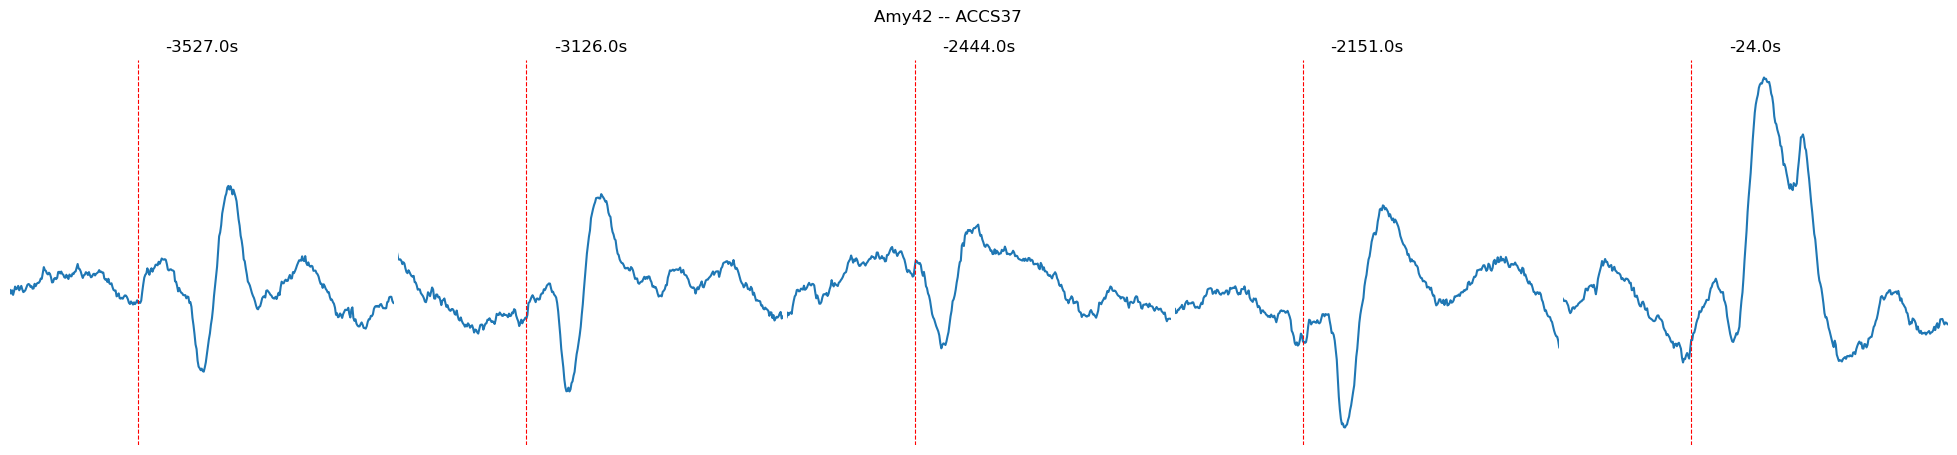

In [674]:
fig, axes = plt.subplots(1, len(num), figsize=(25, 5), sharey=True, sharex = True, gridspec_kw={'wspace': 0.01})
plt.suptitle(labels_all[sc]+ ' -- '+labels_all[rc])
# Plot each trial one after the other
ictal = 0
for i in range(len(num)):
    trial_data = channel_data[i, :]
    d_sec = trials_preictal.loc[(trials_preictal.Chan == rc)&(trials_preictal.Stim == sc), 'TtSZ_s'].values[i]
    
    if (ictal ==0)& ( d_sec >0):
        axes[i].axvline(x=-0.25, color='g', linestyle='--', linewidth=0.8)
        ictal = 1
    axes[i].set_title(str(d_sec)+'s')
    axes[i].plot(x_ax, trial_data)
    axes[i].axvline(x=0, color='r', linestyle='--', linewidth=0.8)
    axes[i].axis('off')
    # Show xticks only at time 0 and time 0.5s
    #axes[i].set_xticks([0, 0.5 * Fs])
    #axes[i].set_xticklabels([0, 0.5])
# plt.ylim([-400,400])    
plt.xlim([-0.25, 0.5])
plt.xlabel('Time [s]')
plt.show()

In [702]:
trials_preictal

,SOZ,Chan,Stim,Artefact,Num_block,Date,LL_pre,LL_WOI,Sig,Ictal,...,Block,LL,Hour,Num,P2P,P2P_BL,d,Time,Con_ID,TtSZ_s
0,uninvolved,52,73,0.0,326,20230511.0,2.861001,5.184197,1,0,...,29.0,5.654265,2.0,13433,359.076203,553.486447,27.88,2023-05-11 02:45:24,6482,-3599.0
1,Propagation,59,73,0.0,326,20230511.0,1.667658,3.149242,1,0,...,29.0,3.444359,2.0,13433,241.445933,278.444683,17.58,2023-05-11 02:45:24,6489,-3599.0
2,Propagation,60,73,0.0,326,20230511.0,2.712087,5.137053,1,0,...,29.0,5.303823,2.0,13433,571.545659,279.135653,16.12,2023-05-11 02:45:24,6490,-3599.0
3,uninvolved,65,73,0.0,326,20230511.0,2.370768,4.280688,1,0,...,29.0,4.280688,2.0,13433,262.703826,623.236464,19.53,2023-05-11 02:45:24,6493,-3599.0
4,uninvolved,66,73,0.0,326,20230511.0,2.120589,5.968435,1,0,...,29.0,6.011843,2.0,13433,533.001131,475.386583,21.89,2023-05-11 02:45:24,6494,-3599.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,Propagation,60,57,0.0,130,20230511.0,1.250803,1.633287,1,1,...,30.0,1.873252,3.0,13962,188.288501,350.936305,10.50,2023-05-11 03:48:20,5203,177.0
4997,Propagation,68,57,0.0,130,20230511.0,3.794431,3.065186,1,1,...,30.0,4.083711,3.0,13962,546.209749,892.057927,14.42,2023-05-11 03:48:20,5209,177.0
4998,Propagation,69,57,0.0,130,20230511.0,5.353388,2.040362,0,1,...,30.0,3.417541,3.0,13962,438.431613,922.327036,14.61,2023-05-11 03:48:20,5210,177.0
4999,Propagation,70,57,0.0,130,20230511.0,2.944097,1.738195,0,1,...,30.0,2.316390,3.0,13962,298.764472,566.884577,15.61,2023-05-11 03:48:20,5211,177.0


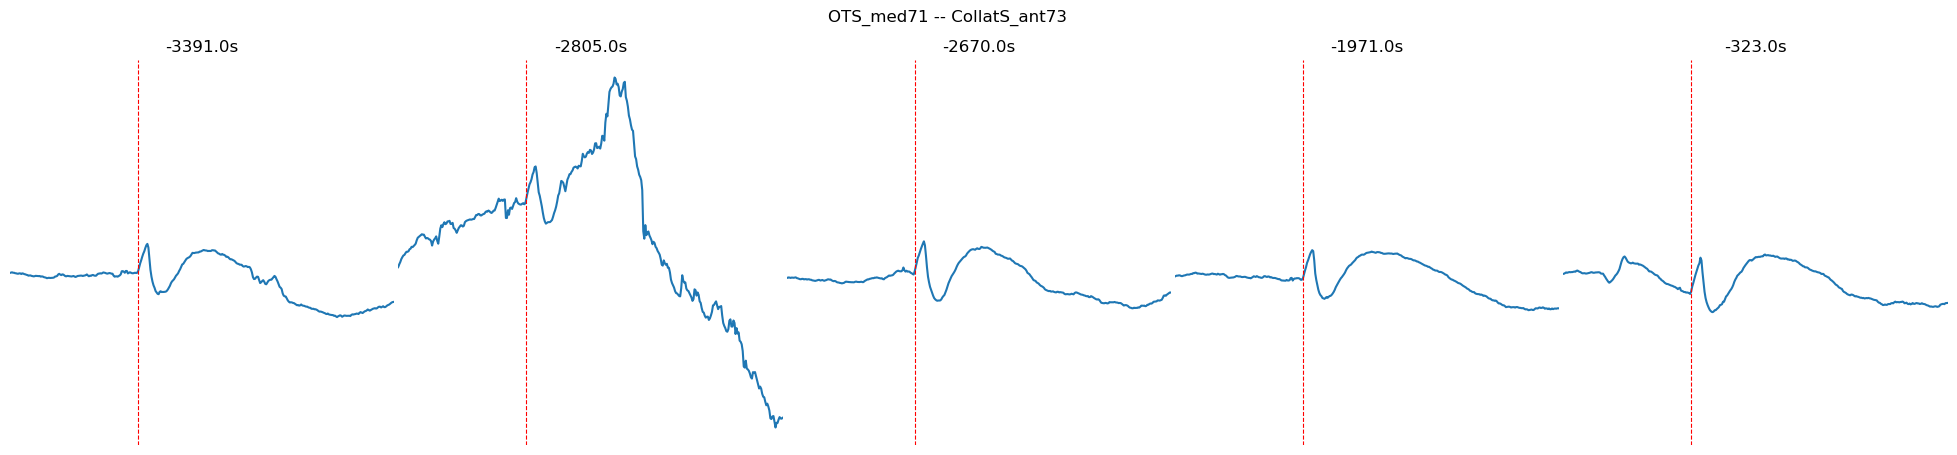

In [703]:

rc = 72
sc = 70
num = trials_preictal.loc[(trials_preictal.Chan == rc)&(trials_preictal.Stim == sc), 'Num'].values
channel_data = EEG_resp[rc, num, :]  # Shape: (num, 2000)
fig, axes = plt.subplots(1, len(num), figsize=(25, 5), sharey=True, sharex = True, gridspec_kw={'wspace': 0.01})
plt.suptitle(labels_all[sc]+ ' -- '+labels_all[rc])
# Plot each trial one after the other
ictal = 0
for i in range(len(num)):
    trial_data = channel_data[i, :]
    d_sec = trials_preictal.loc[(trials_preictal.Chan == rc)&(trials_preictal.Stim == sc), 'TtSZ_s'].values[i]
    
    if (ictal ==0)& ( d_sec >0):
        axes[i].axvline(x=-0.25, color='g', linestyle='--', linewidth=0.8)
        ictal = 1
    axes[i].set_title(str(d_sec)+'s')
    axes[i].plot(x_ax, trial_data)
    axes[i].axvline(x=0, color='r', linestyle='--', linewidth=0.8)
    axes[i].axis('off')
    # Show xticks only at time 0 and time 0.5s
    #axes[i].set_xticks([0, 0.5 * Fs])
    #axes[i].set_xticklabels([0, 0.5])
# plt.ylim([-600,800])    
plt.xlim([-0.25, 0.5])
plt.xlabel('Time [s]')
plt.show()

In [ ]:
D_out = con_trial_clean.groupby(['Stim', 'Num', 'Time'], as_index=False)['LL_sig'].sum()
D_out.insert(3, 'SZ', 'BL')
D_out.loc[((pd.to_datetime(D_out['Time'])- time_sz)<timedelta(seconds = -600))& ((pd.to_datetime(D_out['Time'])- time_sz)>timedelta(seconds = -3600)), 'SZ'] = 'BL(1h pre Sz)'

D_out.loc[((pd.to_datetime(D_out['Time'])- time_sz)<timedelta(seconds = 0))& ((pd.to_datetime(D_out['Time'])- time_sz)>timedelta(seconds = -600)), 'SZ'] = 'preIctal'
D_out.loc[((pd.to_datetime(D_out['Time'])- time_sz)<timedelta(seconds = 60))&((pd.to_datetime(D_out['Time'])- time_sz)>timedelta(seconds = 0)), 'SZ'] = 'Ictal'
D_out.loc[((pd.to_datetime(D_out['Time'])- time_sz)<timedelta(seconds = 600))&((pd.to_datetime(D_out['Time'])- time_sz)>timedelta(seconds = 60)), 'SZ'] = 'Ictal'

In [ ]:
D_in = con_trial_clean.groupby(['Chan', 'Num', 'Time'], as_index=False)['LL_sig'].sum()
D_in.insert(3, 'SZ', 'BL')
D_in.loc[((pd.to_datetime(D_in['Time'])- time_sz)<timedelta(seconds = -600))& ((pd.to_datetime(D_in['Time'])- time_sz)>timedelta(seconds = -3600)), 'SZ'] = 'BL(1h pre Sz)'

D_in.loc[((pd.to_datetime(D_in['Time'])- time_sz)<timedelta(seconds = 0))& ((pd.to_datetime(D_in['Time'])- time_sz)>timedelta(seconds = -600)), 'SZ'] = 'preIctal'
D_in.loc[((pd.to_datetime(D_in['Time'])- time_sz)<timedelta(seconds = 60))&((pd.to_datetime(D_in['Time'])- time_sz)>timedelta(seconds = 0)), 'SZ'] = 'Ictal'
D_in.loc[((pd.to_datetime(D_in['Time'])- time_sz)<timedelta(seconds = 600))&((pd.to_datetime(D_in['Time'])- time_sz)>timedelta(seconds = 60)), 'SZ'] = 'Ictal'

In [ ]:
sc = -1

In [ ]:
cluster_method = 'similarity'
file_CC_summ = path_patient_analysis + '\\' + folder + '\\data\\CC_summ_'+cluster_method+'.csv'

CC_summ = pd.read_csv(file_CC_summ)

In [ ]:
sig_con = CC_summ.groupby(['Stim','Chan'], as_index=False)['sig'].mean()
sig_con = sig_con[sig_con.sig>0].reset_index(drop=True)

In [ ]:
ix_chan= -1

In [ ]:
ix_chan = ix_chan+1
rc = resp_chan[ix_chan]
num = con_trial.loc[(con_trial.Stim==10)&(con_trial.Chan==rc), 'Num'].values
plt.plot(x_ax, np.mean(EEG_resp[rc, num, :],0))

In [ ]:
ix_chan = -1

In [ ]:
ix_chan = ix_chan+1

sc = 0 #chan_SOZ[0]

resp_chan = sig_con.loc[sig_con.Stim == sc, 'Chan'].values.astype('int')
rc = resp_chan[ix_chan]
d = con_trial.loc[(con_trial.Stim==sc)&(con_trial.Chan==rc), 'd'].values[0]
data_show = D_out[D_out.Stim == sc]
num = data_show.loc[(data_show.SZ =='Ictal')|(data_show.SZ =='preIctal')|(data_show.SZ =='BL2'), 'Num'].values
channel_data = EEG_resp[rc, num, :]  # Shape: (num, 2000)
fig, axes = plt.subplots(1, len(num), figsize=(25, 5), sharey=True, sharex = True, gridspec_kw={'wspace': 0.01})
plt.suptitle(labels_all[sc]+ ' -- '+labels_all[rc]+', d='+str(d)+'mm')
# Plot each trial one after the other
ictal = 0
for i in range(len(num)):
    trial_data = channel_data[i, :]
    d_sec = (pd.to_datetime(D_out.loc[D_out.Num == num[i], 'Time'].values[0])-time_sz).total_seconds()
    
    if (ictal ==0)& ( d_sec >0):
        axes[i].axvline(x=-0.25, color='g', linestyle='--', linewidth=0.8)
        ictal = 1
    axes[i].set_title(str(d_sec)+'s')
    axes[i].plot(x_ax, trial_data)
    axes[i].axvline(x=0, color='r', linestyle='--', linewidth=0.8)
    axes[i].axis('off')
    # Show xticks only at time 0 and time 0.5s
    #axes[i].set_xticks([0, 0.5 * Fs])
    #axes[i].set_xticklabels([0, 0.5])
plt.ylim([-600,600])    
plt.xlim([-0.25, 1])
plt.xlabel('Time [s]')
plt.show()

In [ ]:
sc = -1

In [ ]:
stim_chan = sig_con.loc[sig_con.Chan == rc, 'Stim'].values.astype('int')

In [ ]:
ix_chan = -1

In [ ]:
ix_chan = ix_chan+1

rc = 9 #chan_SOZ[0]

stim_chan = sig_con.loc[sig_con.Chan == rc, 'Stim'].values.astype('int')
sc = stim_chan[ix_chan]
d = con_trial.loc[(con_trial.Stim==sc)&(con_trial.Chan==rc), 'd'].values[0]
data_show = D_out[D_out.Stim == sc]
num = data_show.loc[(data_show.SZ =='Ictal')|(data_show.SZ =='preIctal')|(data_show.SZ =='BL2'), 'Num'].values
channel_data = EEG_resp[rc, num, :]  # Shape: (num, 2000)
fig, axes = plt.subplots(1, len(num), figsize=(25, 5), sharey=True, sharex = True, gridspec_kw={'wspace': 0.01})
plt.suptitle(labels_all[sc]+ ' -- '+labels_all[rc]+', d='+str(d)+'mm')
# Plot each trial one after the other
ictal = 0
for i in range(len(num)):
    trial_data = channel_data[i, :]
    d_sec = (pd.to_datetime(D_out.loc[D_out.Num == num[i], 'Time'].values[0])-time_sz).total_seconds()
    
    if (ictal ==0)& ( d_sec >0):
        axes[i].axvline(x=-0.25, color='g', linestyle='--', linewidth=0.8)
        ictal = 1
    axes[i].set_title(str(d_sec)+'s')
    axes[i].plot(x_ax, trial_data)
    axes[i].axvline(x=0, color='r', linestyle='--', linewidth=0.8)
    axes[i].axis('off')
    # Show xticks only at time 0 and time 0.5s
    #axes[i].set_xticks([0, 0.5 * Fs])
    #axes[i].set_xticklabels([0, 0.5])
plt.ylim([-600,600])    
plt.xlim([-0.25, 1])
plt.xlabel('Time [s]')
plt.show()

In [ ]:
fig, axes = plt.subplots(1, len(num), figsize=(25, 5), sharey=True, sharex = True, gridspec_kw={'wspace': 0.01})
plt.suptitle(labels_all[sc]+ ' -- '+labels_all[rc]+', d='+str(d)+'mm')
# Plot each trial one after the other
ictal = 0
for i in range(len(num)):
    trial_data = channel_data[i, :]
    d_sec = (pd.to_datetime(D_out.loc[D_out.Num == num[i], 'Time'].values[0])-time_sz).total_seconds()
    
    if (ictal ==0)& ( d_sec >0):
        axes[i].axvline(x=-0.25, color='g', linestyle='--', linewidth=0.8)
        ictal = 1
    axes[i].set_title(str(d_sec)+'s')
    axes[i].plot(x_ax, trial_data)
    axes[i].axvline(x=0, color='r', linestyle='--', linewidth=0.8)
    axes[i].axis('off')
    # Show xticks only at time 0 and time 0.5s
    #axes[i].set_xticks([0, 0.5 * Fs])
    #axes[i].set_xticklabels([0, 0.5])
plt.ylim([-1000,1000])    
plt.xlim([-0.25, 1])
plt.xlabel('Time [s]')
plt.show()